In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm
import cvxopt

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

In [4]:
en = 3
ch = 3
P = np.array([.2,.4,.4])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
R = np.array([8.,6.,4.])
# P = row_normalize([np.random.rand(ch)/2])[0]
# E = np.random.rand(en,ch)/2
# R = np.array([np.random.randint(1,10) for i in range(en)])
tol = .3
print(P)
print(E)
print(R)
print(tol)

[0.2 0.4 0.4]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[8. 6. 4.]
0.3


In [23]:
# example 2
en = 6
ch = 8
P = np.array([.3,.1,.2,.4,.3,.1,.3,.3])/2
E = np.array([[.4,.6,.4,.3,.1,.35,.3,.4],[.3,.4,.4,.3,.3,.35,.25,.4],[.3,.2,.1,.4,.3,.4,.4,.3],[.4,.3,.3,.5,.6,.4,.55,.35],[.2,.4,.1,.3,.4,.4,.3,.1],[.4,.6,.4,.3,.6,.4,.3,.1]])/2
R = np.array([4.,3.5,4.,8.,2.,3.])
tol = .2
print(P)
print(E)
print(R)
print(tol)

[0.15 0.05 0.1  0.2  0.15 0.05 0.15 0.15]
[[0.2   0.3   0.2   0.15  0.05  0.175 0.15  0.2  ]
 [0.15  0.2   0.2   0.15  0.15  0.175 0.125 0.2  ]
 [0.15  0.1   0.05  0.2   0.15  0.2   0.2   0.15 ]
 [0.2   0.15  0.15  0.25  0.3   0.2   0.275 0.175]
 [0.1   0.2   0.05  0.15  0.2   0.2   0.15  0.05 ]
 [0.2   0.3   0.2   0.15  0.3   0.2   0.15  0.05 ]]
[4.  3.5 4.  8.  2.  3. ]
0.2


In [24]:
ub = np.sum(E*P,axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

6.518518518518519 1.0 [0.] True 0.2
[0.         0.         0.37037037 0.62962963 0.         0.        ]


In [25]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

6 8 0.2 6.518518518518519 0.13
[0.15 0.05 0.1  0.2  0.15 0.05 0.15 0.15]
[[0.2   0.3   0.2   0.15  0.05  0.175 0.15  0.2  ]
 [0.15  0.2   0.2   0.15  0.15  0.175 0.125 0.2  ]
 [0.15  0.1   0.05  0.2   0.15  0.2   0.2   0.15 ]
 [0.2   0.15  0.15  0.25  0.3   0.2   0.275 0.175]
 [0.1   0.2   0.05  0.15  0.2   0.2   0.15  0.05 ]
 [0.2   0.3   0.2   0.15  0.3   0.2   0.15  0.05 ]]
[0.         0.         0.37037037 0.62962963 0.         0.        ]


In [26]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0], bounds=(.05,1.0),method='revised simplex',options={'tol': 1.0e-1})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to make safe matrix dense 0.05
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
# yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
# yt = row_normalize([np.exp(yt)]).transpose()
# c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),np.max(np.matmul(x0.transpose(),E)),dot(x0.transpose(),R))

[0.3875 0.05   0.4125 0.05   0.05   0.05  ] 0.20000000000000004 4.025


In [27]:
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':False,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl','maxiters':30

In [34]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.01 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.01 # >= 1, ellipse radii
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1].transpose(),R)];c = [0.0]
b = []; enc = [];chnl = []
rate = []
alfa_c1 = alfa_c
alfa_c2 = alfa_c

In [35]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
tolx = tol
step = 50
for t in range(1,2000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    # yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    # yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],R))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
    betat = Ra*math.sqrt(en*math.log((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    d = -2*alfa_c1*betat
    l = alfa_c2*betat*(1+pow(dot(e0,e0),2.0))
    C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
    if t%step == 0:
        tolx += (tol-np.mean(c))
    sol = qclp_solver(A,C,x0,R,en,tolx)
    x.append(sol[0])
    rate.append(dot(x[-1].transpose(),R))
    print(t,rate[-1],sol[1],tolx)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(A,betat)

1 4.544675642439983 0.0014178811232851603 0.2
2 4.544675642482484 0.0017297215708284557 0.2
3 4.5446756424895325 0.001804182933300537 0.2
4 4.544675642493248 0.001847517754118094 0.2
5 4.544675642495695 0.0018779824374403943 0.2
6 4.544675642685677 0.07965784189171855 0.2
7 4.544675642709751 0.07406697841068913 0.2
8 4.544675642731837 0.06922806639418971 0.2
9 4.544675642749354 0.06499912743644728 0.2
10 4.544675642764012 0.06127176682573364 0.2
11 4.544675642775314 0.05796181467865307 0.2
12 4.544675642784076 0.05500292411554189 0.2
13 4.544675642792165 0.052342094609483546 0.2
14 4.544675642808262 0.049936478701352795 0.2
15 4.544675642816994 0.04775106300187363 0.2
16 4.544675642821422 0.04575695667949704 0.2
17 4.544675642380986 0.08584007684718739 0.2
18 4.544675642300591 0.08247451319201829 0.2
19 4.544675642210071 0.07936934022401194 0.2
20 4.544675642110136 0.07649547513018765 0.2
21 4.544675642001443 0.07382801006955499 0.2
22 4.544675641882208 0.0713454890224553 0.2
23 4.5446

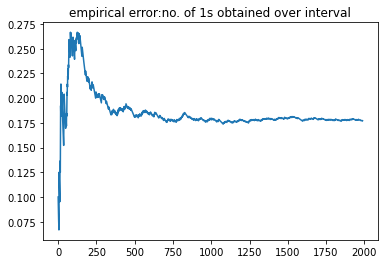

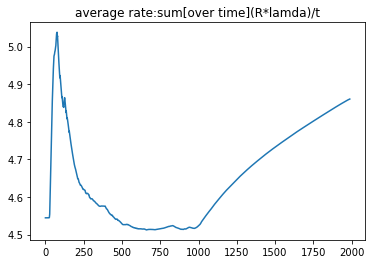

In [39]:
stat = 10
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [37]:
print(x0.flatten())
print(x[-1].flatten(),error_plot[-1],rate_plot[-1])
print(org_x,tol,dot(org_x,R))

[0.3875 0.05   0.4125 0.05   0.05   0.05  ]
[9.76077425e-63 6.01523916e-02 5.68500522e-01 3.37447994e-01
 3.38051699e-02 9.39227770e-05] 0.1771771771771773 4.860552212343756
[0.         0.         0.37037037 0.62962963 0.         0.        ] 0.2 6.518518518518519


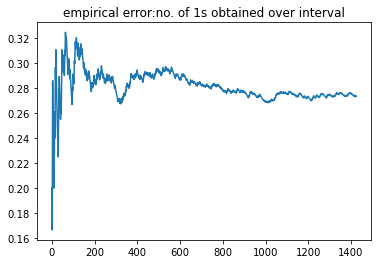

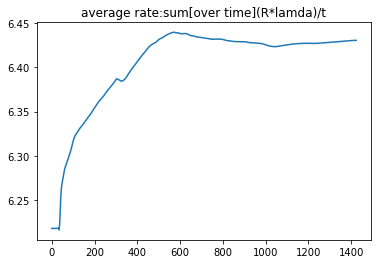

In [21]:
stat = 10
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

8.90142435685489


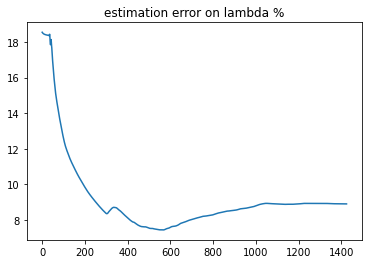

In [22]:
err = []
for i in range(len(x)):
    err.append(np.sqrt(np.sum(np.square(org_x-x[i].flatten()))/en)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[stat:])
plt.title('estimation error on lambda %')
plt.show()

In [ ]:
print(C)
print(A)
print(np.identity(en) - np.matmul(e0,e0_trans))
print(d,l)
print(dot(e0,e0))
print(x[-1])
print(x[0])

In [ ]:
y = np.array([0.1,0.9,0.])
print(np.matmul(A,y.transpose())+np.matmul(np.matmul(y,C),y.transpose()))
print(dot(y,R))

In [ ]:
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]), options={'show_progress':True})
    print(sol['snl'])
    sol = sol['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
ans = qclp_solver(A,C,x0,R,en,tol)
print(ans)
print(dot(ans[0].transpose(),R))

In [ ]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(xopt) 

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4

In [ ]:
import cvxopt
from cvxopt import matrix
def qclp_solver(A,C,x0,Rn,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    Rn = cvxopt.matrix(Rn)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1*Rn, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':True,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
a = matrix([[2.],[3.],[4.]])
b = matrix([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
c = matrix([[7.,9.,11.]])
x0 = matrix([[.9,.05,.05]])
p = qclp_solver(a,b,x0,R,3,3.5)
print(p)
print(c.trans()*matrix(p[0]))

In [ ]:
cvxopt.matrix(R),matrix([[7.,9.,11.]])

In [ ]:
a*x0

In [ ]:
a = matrix([[2.],[3.]])
b = matrix([[1.,2.],[2.,1.]])
c = matrix([[6.],[4.]])
tol = 5
A = matrix([1.0]*2).trans()
def F(x = None, z = None):
    if x is None:  return 1, matrix([[1.,0.]])
    if max(x) > 1.0 or min(x) < 0: return (None,None)
    f = (a*x) +  x.trans()*b*x - tol
    df = a + (2*b*x).trans()
    if z is None: return (f,df)
    h = 2*z*b
    return (f,df,h)

In [ ]:
print(sol['x'])
x = sol['x']
print((a*x) +  x.trans()*b*x - tol)
print(-1*c.trans()*x)

In [ ]:
matrix(np.array([[2.],[3.]])), matrix([[2.],[3.]])

In [ ]:
m = matrix([[1.0]])
print(m - tol, m - matrix([[.2]]))